In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import os
os.chdir("/Users/bytedance/MLTrader-Research/")
import sys
sys.path.insert(0, ".")
import research.orderbook_strategies.utils.helper as helper
import research.orderbook_strategies.utils.factor_analysis as factor_analysis
import research.orderbook_strategies.utils.factors as factors
from research.orderbook_strategies.utils.product_info import product_info
import itertools
import pandas as pd
from collections import OrderedDict
import functools
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import dask
from dask import compute, delayed
warnings.filterwarnings('ignore')
import scipy
from scipy.stats import norm
import seaborn as sns
product_list = ["OPUSDT","BTCUSDT", "ETHUSDT", "APTUSDT", "1000PEPEUSDT"]
ATR_FILTER = 0.02
MAX_SPREAD_RATIO = 1.1
factor = factors.factor_rmi()
periods = factor.params['period']
signal_name_format = factor.factor_name

In [3]:
# %%time
# 构造因子
for product in product_list:
    file_list = helper.get_file_list(product)
    helper.parLapply(file_list, 
                        factor_analysis.build_composite_signal,
                        signal_list=[factor], 
                        product=product,
                        overwrite=True,)

NameError: name 'product_list' is not defined

In [6]:
all_product_signal_periods = {}
for period in periods:
    signal_name = signal_name_format.format(period=period)
    all_product_signal_periods[period] = helper.get_signal_data(product_list, signal_name)


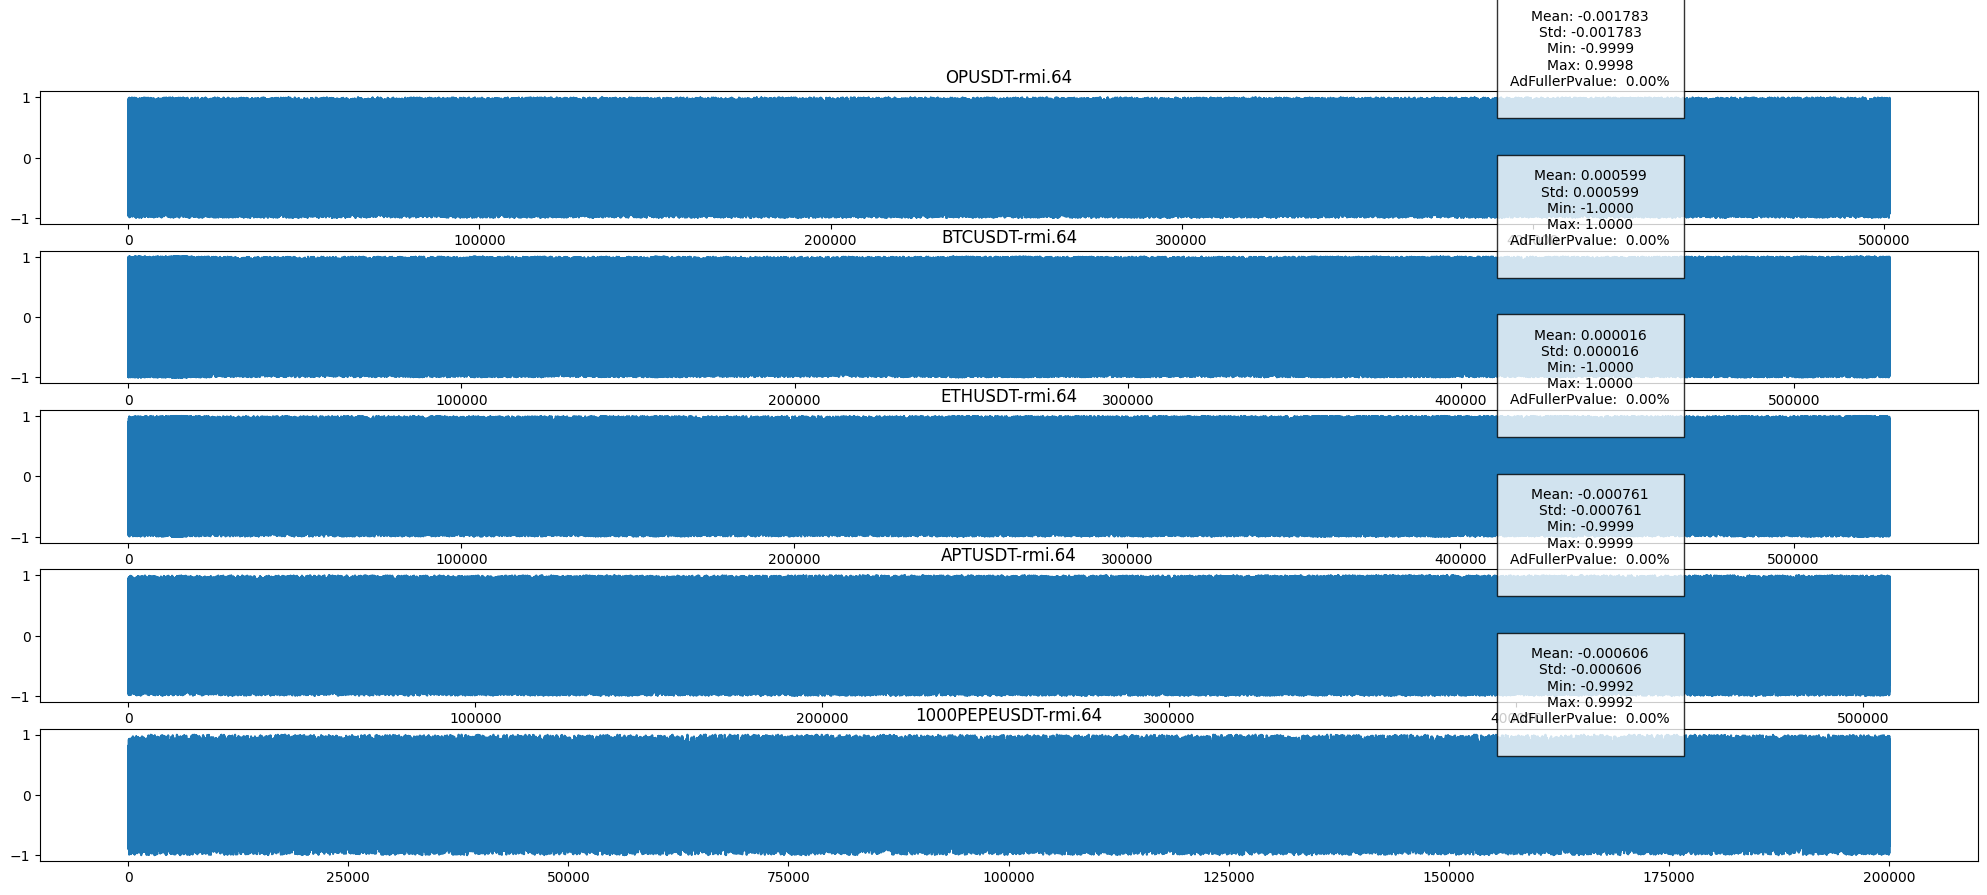

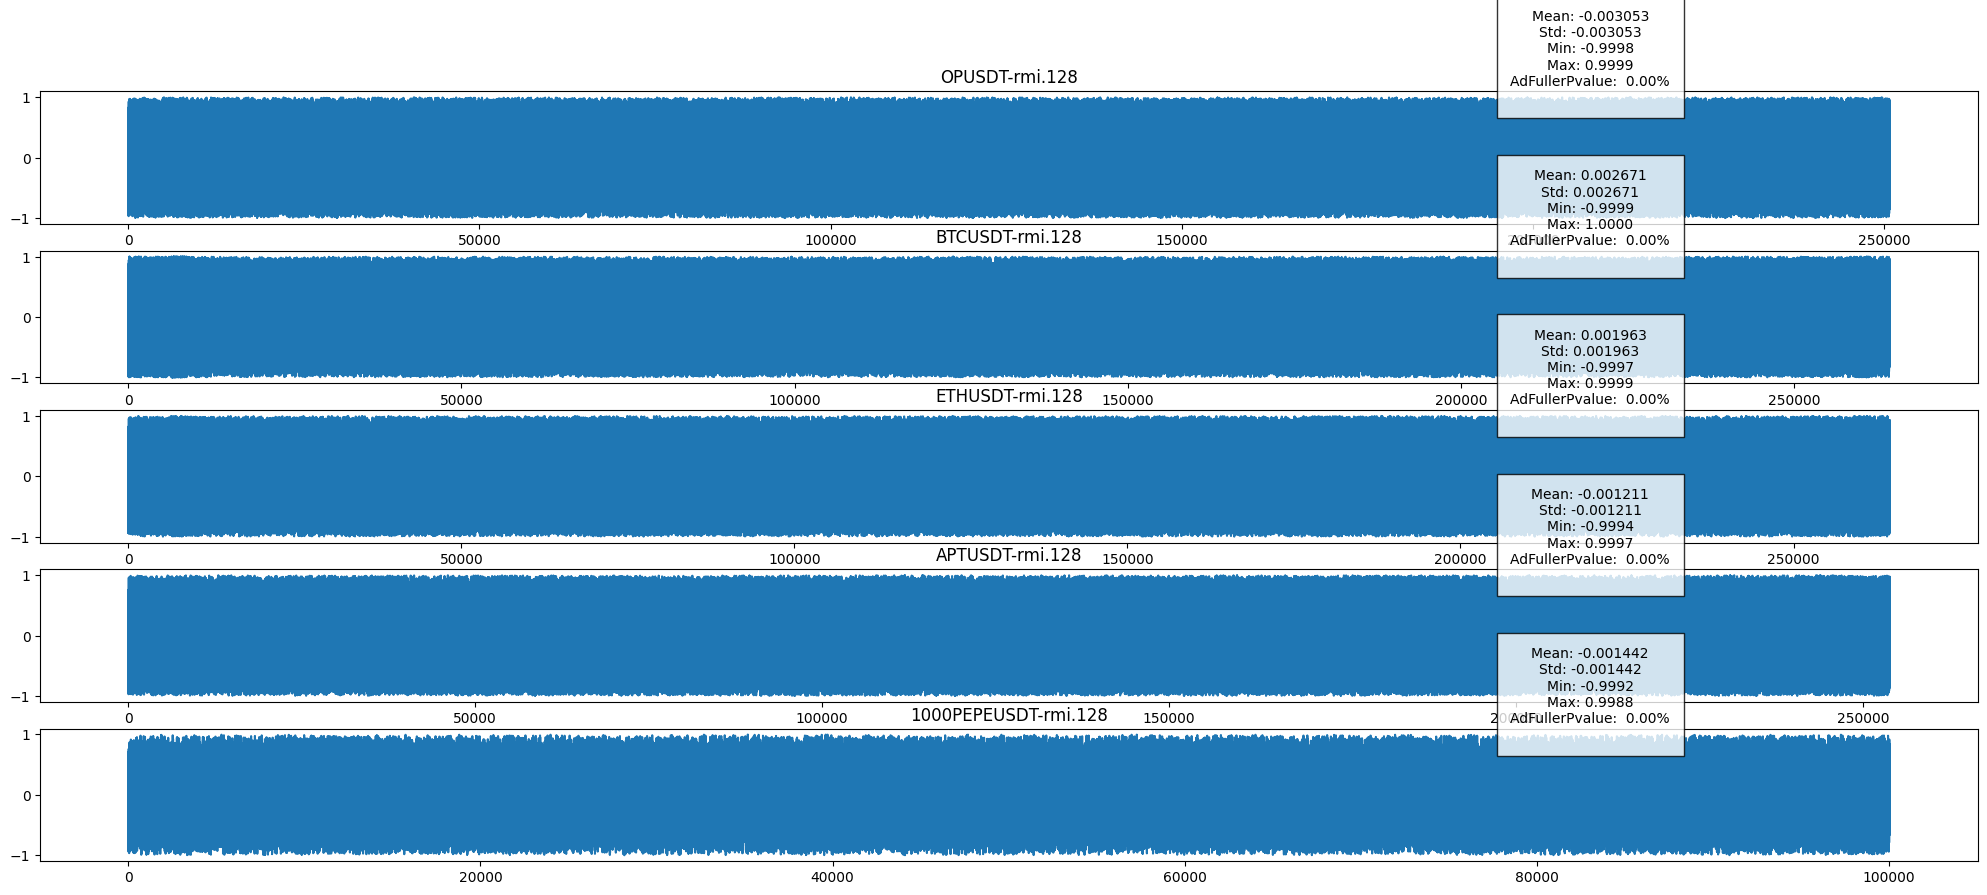

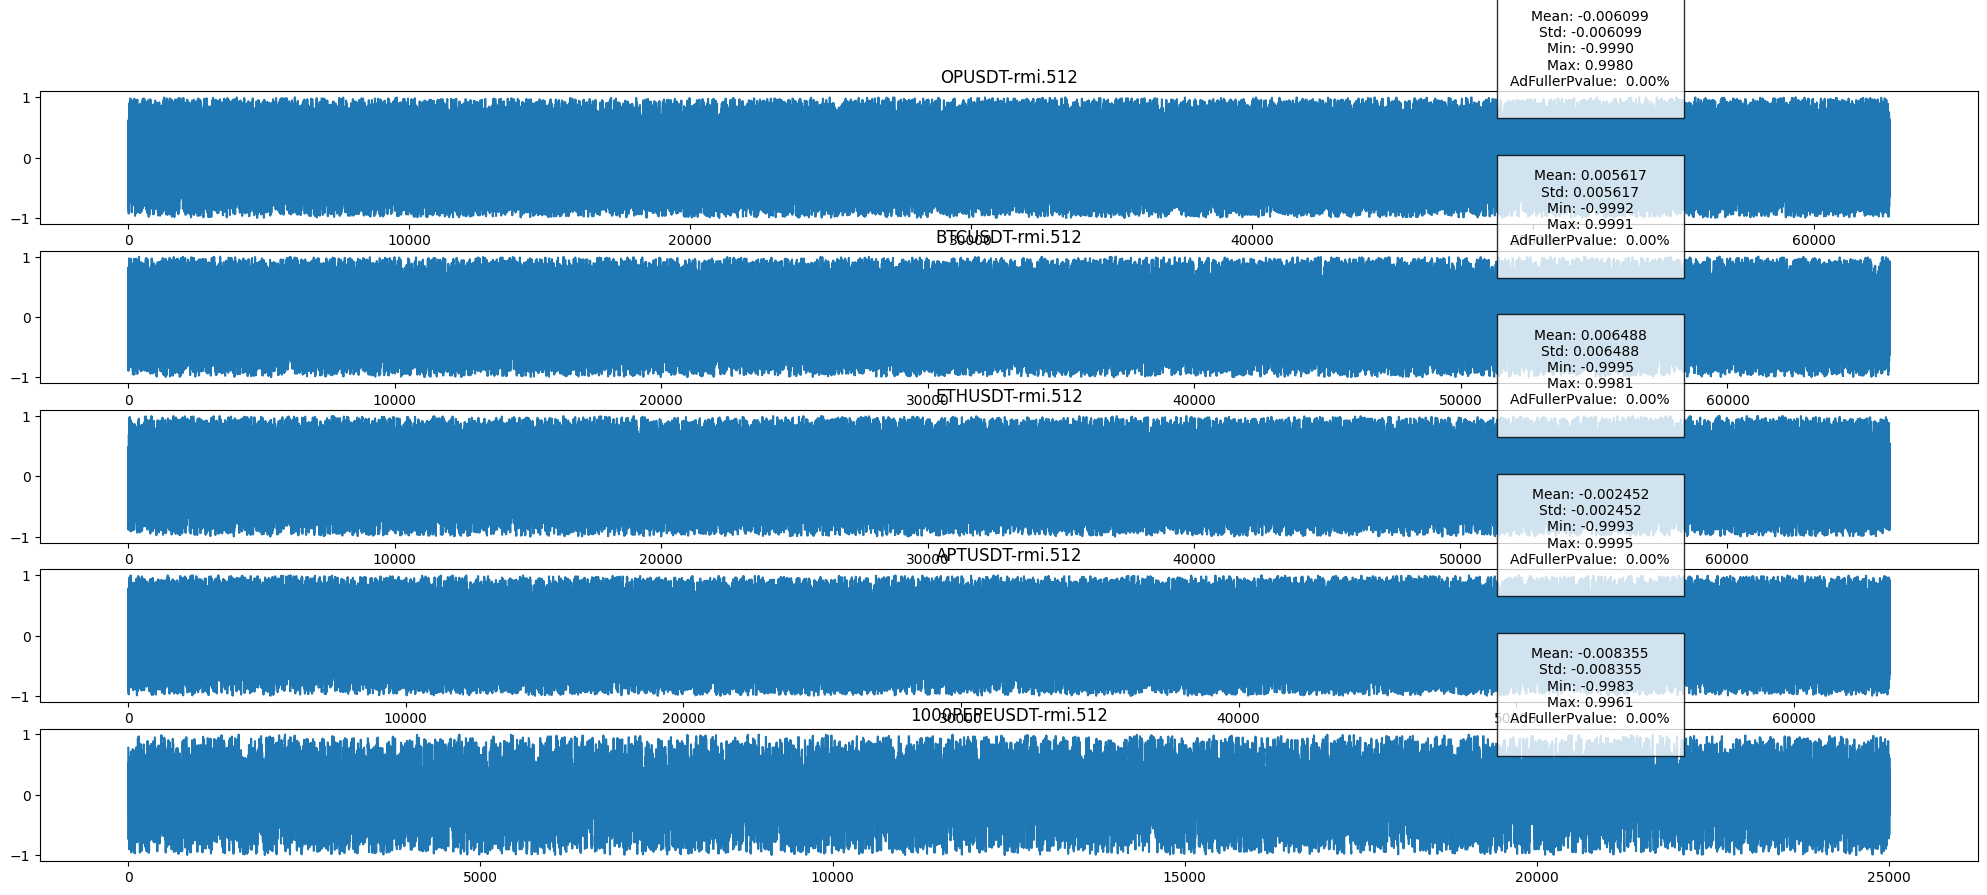

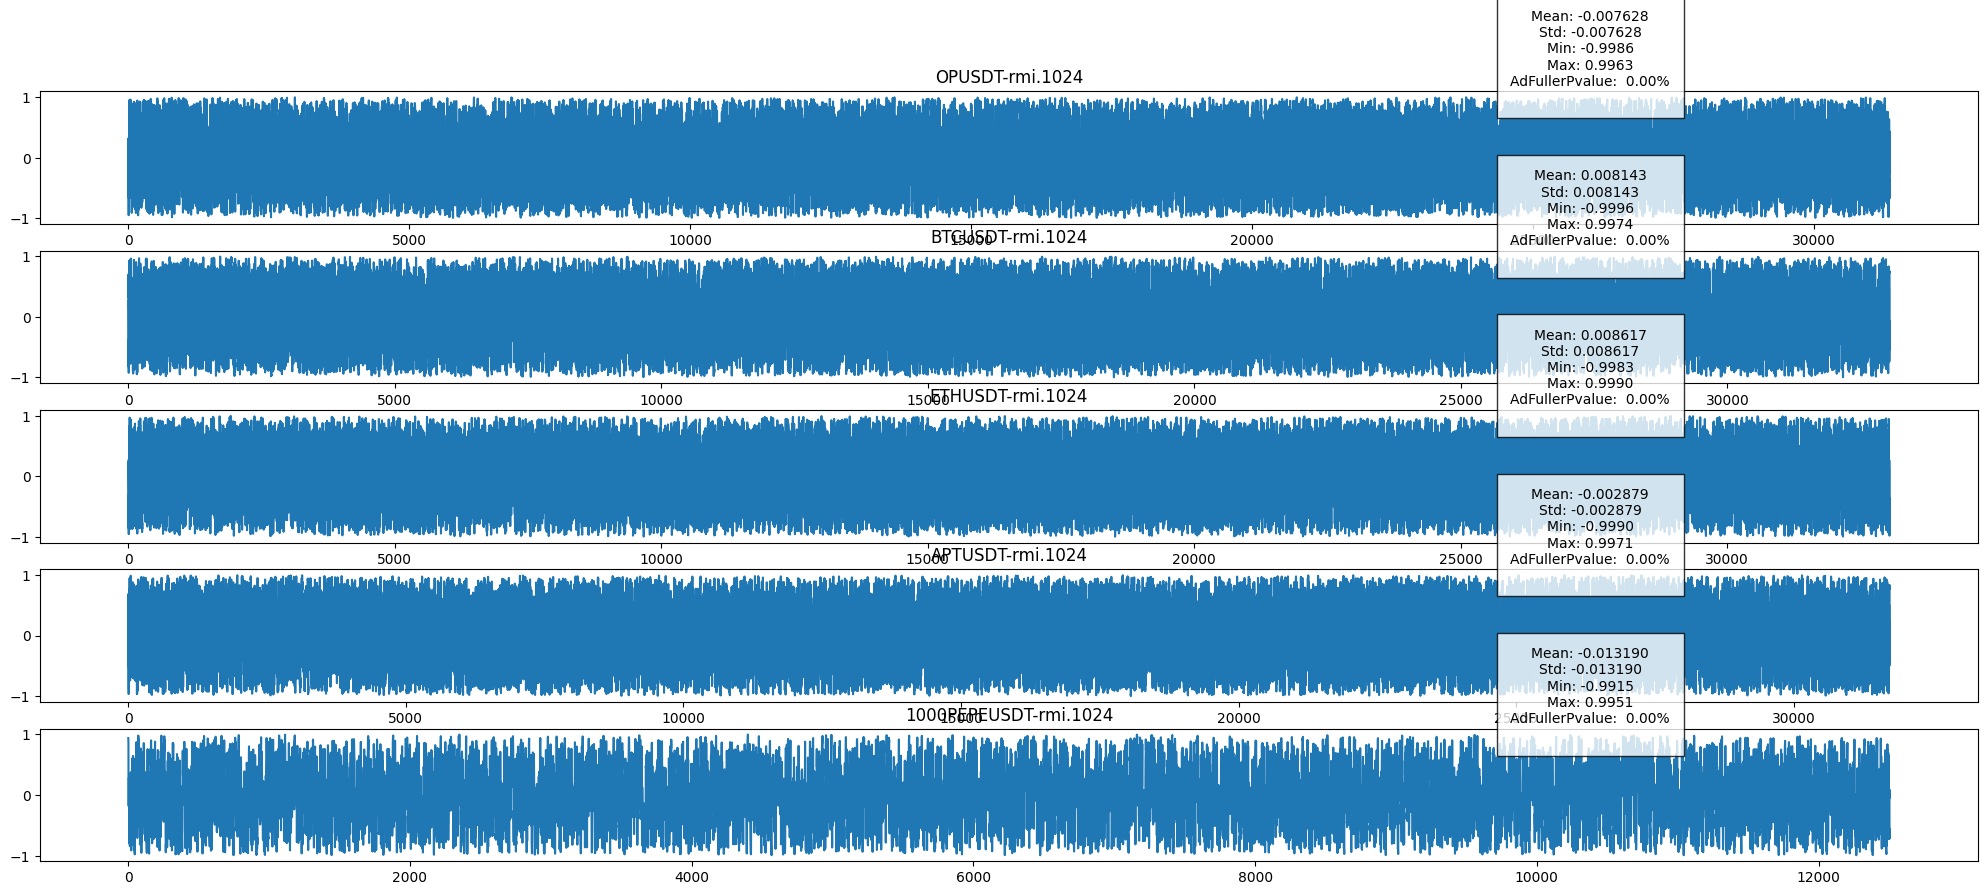

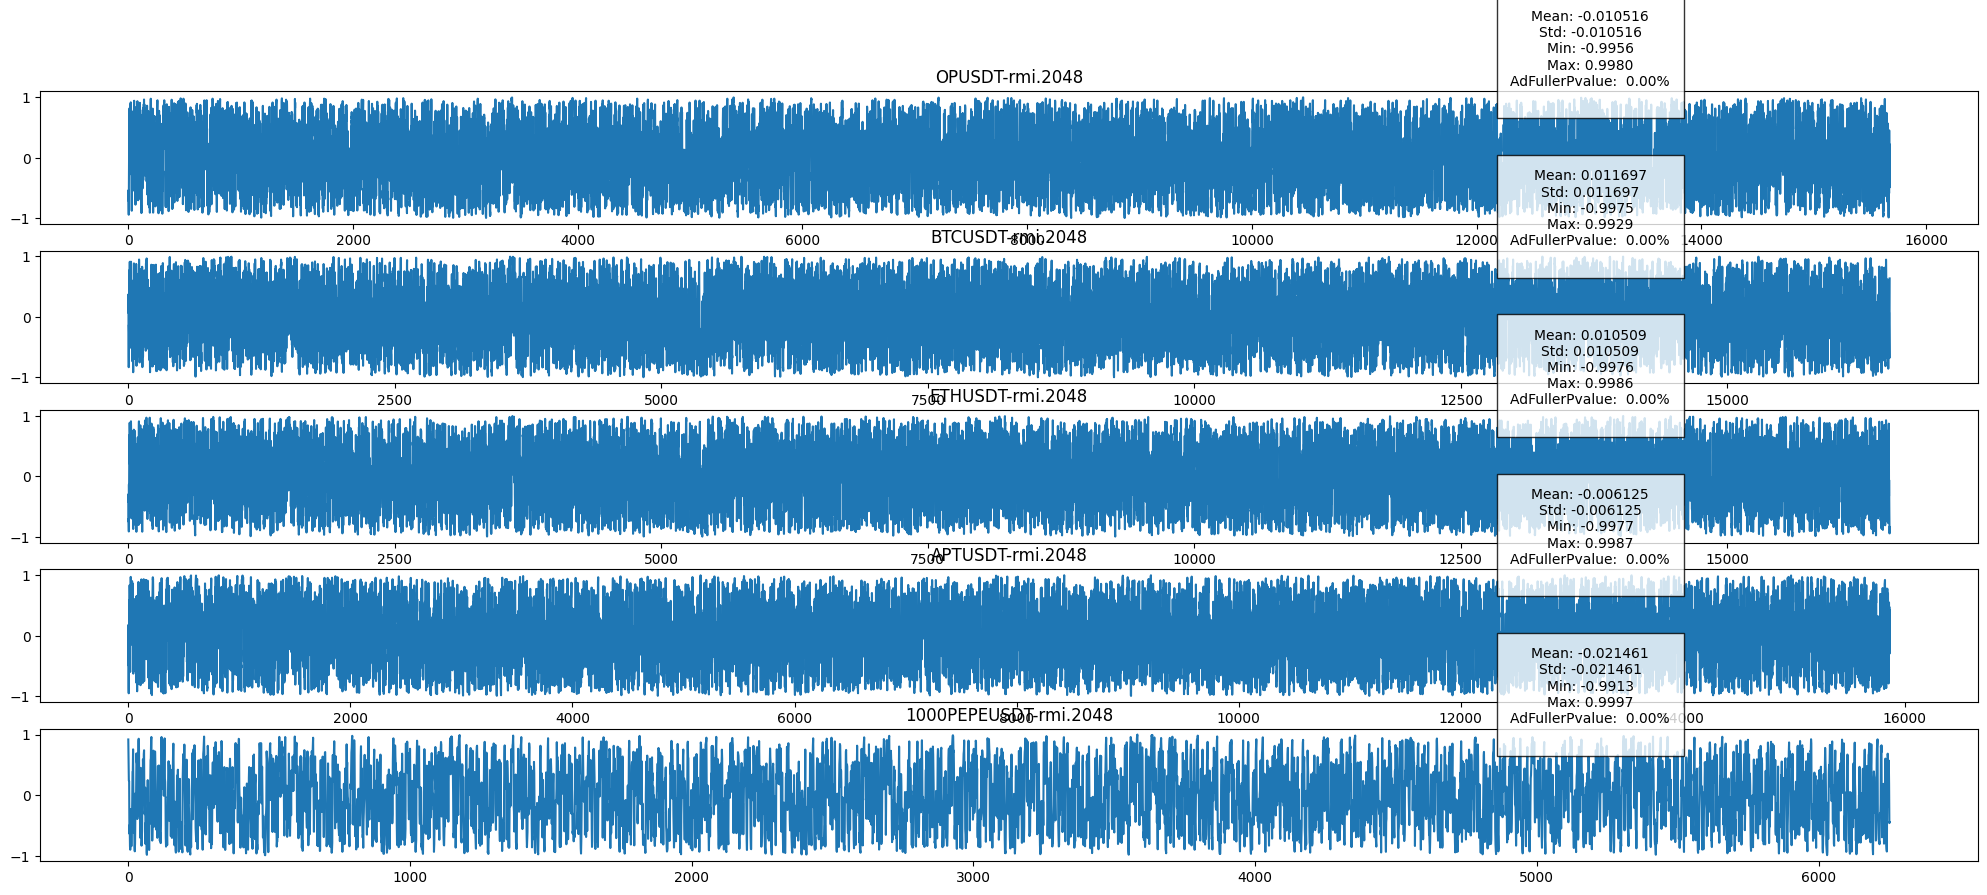

In [7]:
import statsmodels.tsa.stattools as ts
for period in periods:
    f, axes = plt.subplots(len(product_list), 1, figsize=(5 * len(product_list), 10))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        
        T = len(arr)

        arr = arr[np.arange(0, T, period)]
        axes[i].plot(arr)
        axes[i].set_title(product + "-" + signal_name)
        _, p_val, _, _, _ = ts.adfuller(arr, maxlag=int(pow(len(arr)-1,(1/3))), regression='ct', autolag=None)
        
        mean = np.nanmean(arr)
        std = np.nanmean(arr)
        min_val = np.nanmin(arr)
        max_val = np.nanmax(arr)
        summary_text = f"Mean: {mean:.6f}\nStd: {std:.6f}\nMin: {min_val:.4f}\nMax: {max_val:.4f}\nAdFullerPvalue: {p_val: .2%}\n"
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

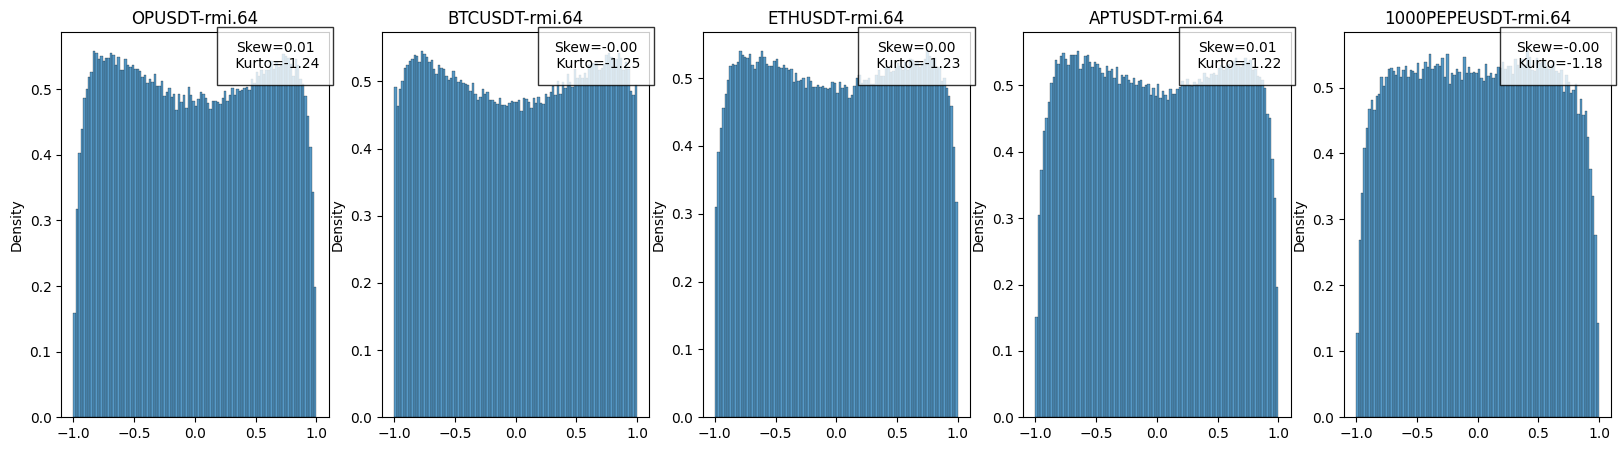

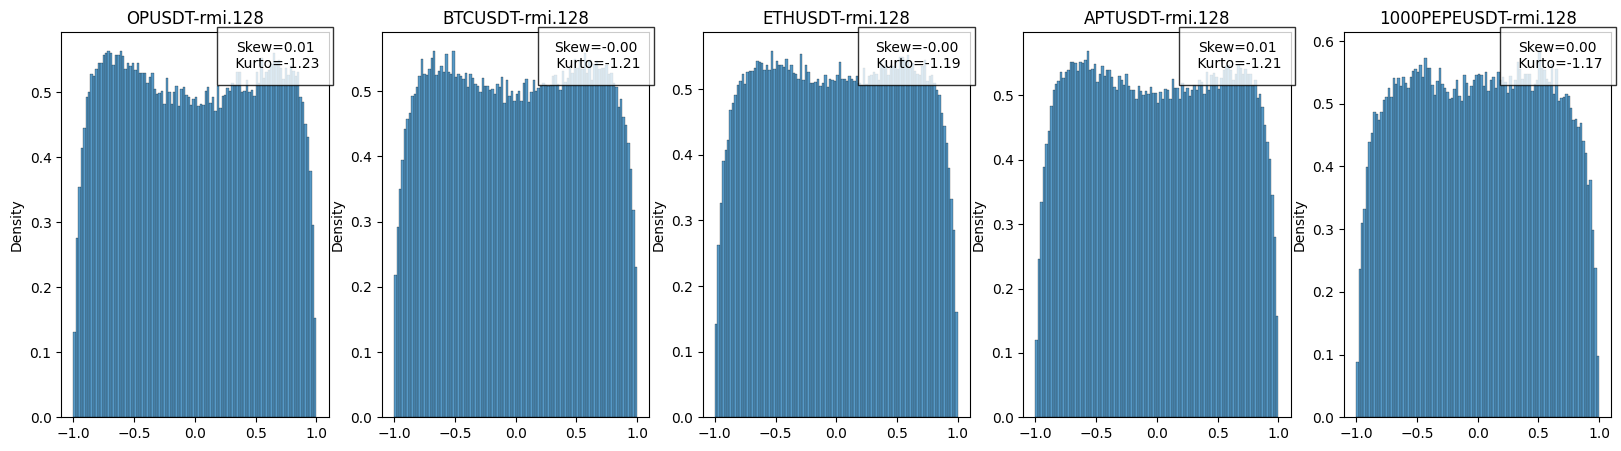

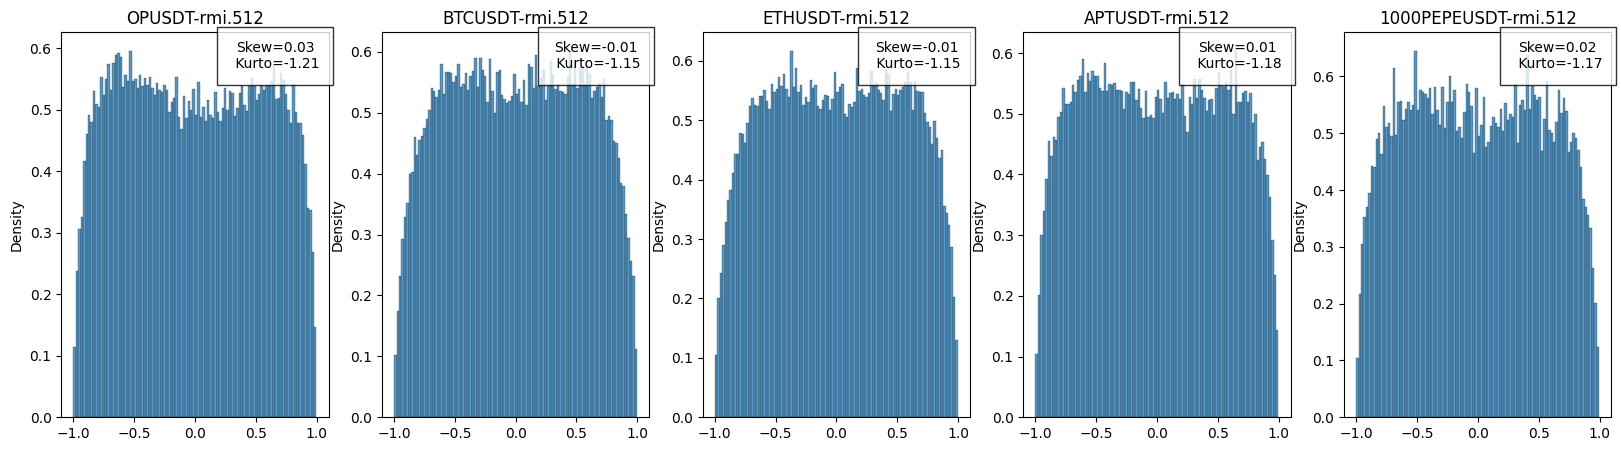

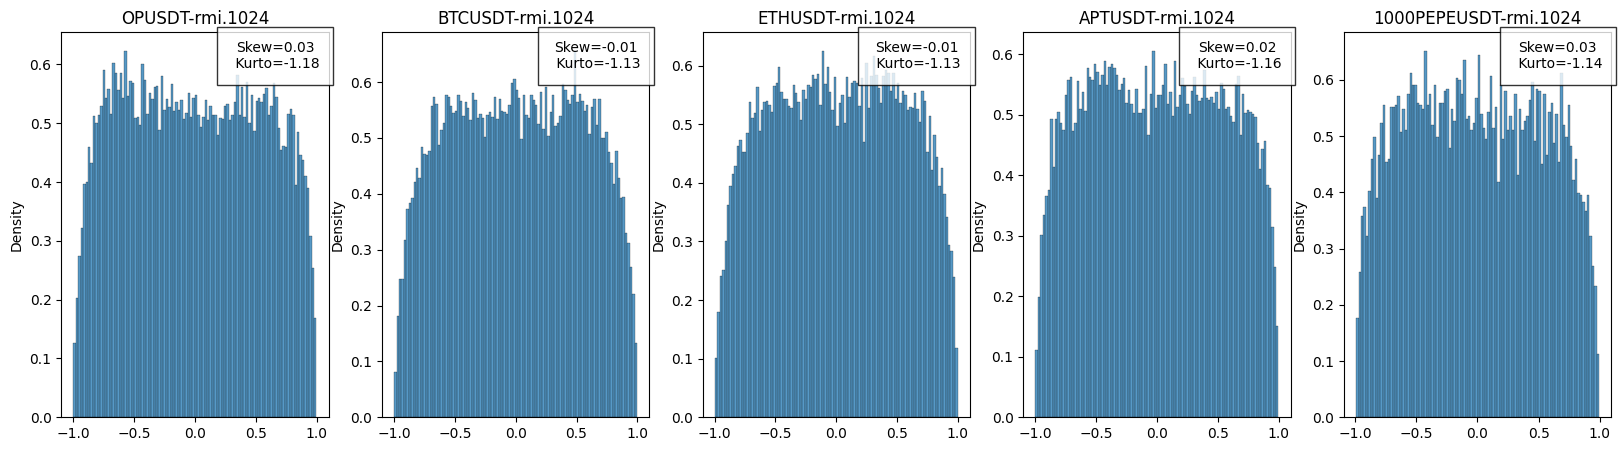

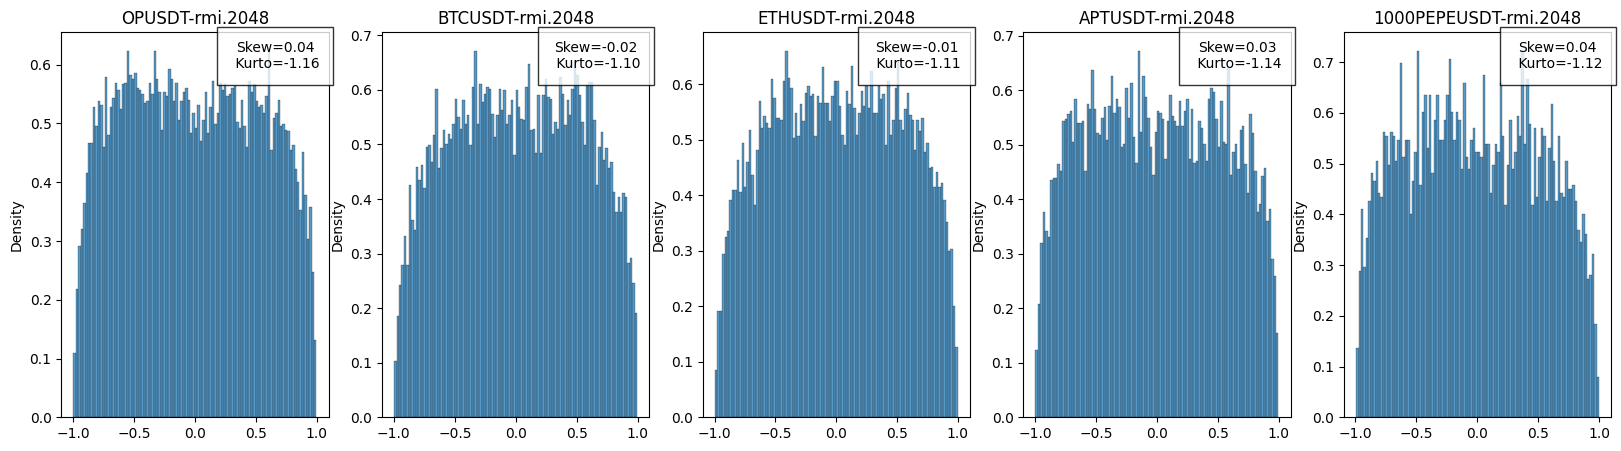

In [8]:
for period in periods:
    f, axes = plt.subplots(1, len(product_list), figsize=(20, 5))
    signal_name = signal_name_format.format(period=period)
    for i, product in enumerate(product_list):
        arr = all_product_signal_periods[period][product]
        T = len(arr)
        arr = arr[np.arange(0, T, period)]
        skew = scipy.stats.skew(arr)
        kurto = scipy.stats.kurtosis(arr)
        summary_text = f"Skew={skew:.2f}\n Kurto={kurto:.2f}"
        # Plot the empirical histogram
        sns.histplot(arr, kde=False, bins=100, stat='density', label='Empirical', ax=axes[i])

        # # Fit a normal distribution to the data
        # mean, std = norm.fit(data)

        # # Generate values for the estimated normal distribution
        # x = np.linspace(min(data), max(data), 100)
        # y = norm.pdf(x, mean, std)

        # axes[i].plot(x, y, label='Estimated', color='red')
        axes[i].set_title(product + "-" + signal_name)
        axes[i].text(0.8, 0.9, summary_text, transform=axes[i].transAxes, ha='center', va='bottom',
                bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 10})
    f.show()

In [5]:
trades_signal_period = [signal_name_format.format(period=period) for period in periods]
results = factor_analysis.get_signal_performance_result(trades_signal_period, "signal_result_with_atr", product_list, 1e-4, 1)

trend_res = results['trend.signal.stat']
reve_res = results["reverse.signal.stat"]
signal_trend_res = trend_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']
signal_rever_res = reve_res[['signal', 'trainSharpe']].set_index('signal')['trainSharpe']

trend_signals = signal_trend_res[(signal_trend_res - signal_rever_res) > 0].index
reverse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) < 0].index
nouse_signals = signal_trend_res[(signal_trend_res - signal_rever_res) == 0].index

print("#trend={}, #reverse={}, #nouse={}".format(len(trend_signals), len(reverse_signals), len(nouse_signals)))

merge_res = pd.concat([trend_res.loc[np.isin(trend_res['signal'], trend_signals)], 
                       reve_res.loc[np.isin(reve_res['signal'], reverse_signals)]], 
                      axis=0)

display(merge_res.sort_values(by='trainSharpe', ascending=False))

#trend=3, #reverse=4, #nouse=0


signal  reverse  num_good_product  \
0    rmi.32  reverse                 5   
1    rmi.64  reverse                 5   
2   rmi.128    trend                 3   
3   rmi.256    trend                 3   
5  rmi.1024  reverse                 2   
4   rmi.512    trend                 5   
6  rmi.2048    trend                 5   

                                  good_product       good_product_sharpe  \
0  OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT  1.49,3.81,5.45,2.96,3.32   
1  OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT    1.02,3.19,3.88,0.6,3.8   
2                  OPUSDT,APTUSDT,1000PEPEUSDT            0.92,2.16,3.21   
3                 BTCUSDT,APTUSDT,1000PEPEUSDT             0.9,2.06,3.02   
5                          OPUSDT,1000PEPEUSDT                 0.46,2.62   
4  OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT    0.76,0.77,0.7,1.5,2.86   
6  OPUSDT,BTCUSDT,ETHUSDT,APTUSDT,1000PEPEUSDT  0.52,0.25,0.51,0.75,1.04   

   trainSharpe  testSharpe  trainSharpeV2  testSharpeV2  \
0     3.406843    2.353787       1.494920     -2.025041   
1     2.499190    0.727288       1.017430     -2.390387   
2     2.097597   -0.645227       0.922315     -0.522802   
3     1.994157   -1.110908       0.899541     -0.286264   
5     1.539892    2.143925       0.463035      1.604595   
4     1.316756   -0.768673       0.758119     -2.011956   
6     0.615771   -0.574665       0.522025     -1.619536   

   trainAvgDailyTradeNum  testAvgDailyTradeNum  sum_good_strat  avgTrainRet  \
0             117.513401             70.882388              79     0.003414   
1              69.576770             49.298179             116     0.003186   
2              28.970162             27.142712              44     0.006835   
3              22.700048             20.028663              83     0.005753   
5               6.738076              6.179651              13     0.003152   
4              22.676244             18.362604              92     0.004088   
6              12.847467             10.644511              47     0.002038   

   avgTestRet  trainReturn  testReturn  
0    0.000613     0.560863    0.040651  
1    0.000472     0.356347    0.013483  
2   -0.001455     0.629171   -0.109799  
3   -0.001900     0.434322   -0.146135  
5    0.003430     0.259893    0.315405  
4   -0.001043     0.373141   -0.102654  
6   -0.000471     0.230871   -0.103934